In [1]:
import librosa
import librosa.feature
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq

# 1. Đọc file âm thanh

In [2]:
file_path = 'data/i.wav'
x, sr = librosa.load(file_path, sr=None)

# Thiết lập thông số

In [3]:
hop_length = int(0.015 * sr)
print('Hop length:', hop_length , 'samples')
frame_length = int(0.03 * sr)
print('Frame length:', frame_length, 'samples')

Hop length: 240 samples
Frame length: 480 samples


# 2. Sử dụng HNR 

In [4]:
stft = np.abs(librosa.stft(x, n_fft=frame_length, hop_length=hop_length))

# Tính năng lượng tín hiệu (dải điều hòa và nhiễu)
harmonics_energy = np.sum(stft[:int(sr // 2), :], axis=0)
noise_energy = np.sum(stft[int(sr // 2):, :], axis=0)

# Tính HNR cho từng frame
HNR = 10 * np.log10(harmonics_energy / (noise_energy + 1e-6))

Text(0.5, 1.0, 'Harmonics-to-Noise Ratio (HNR)')

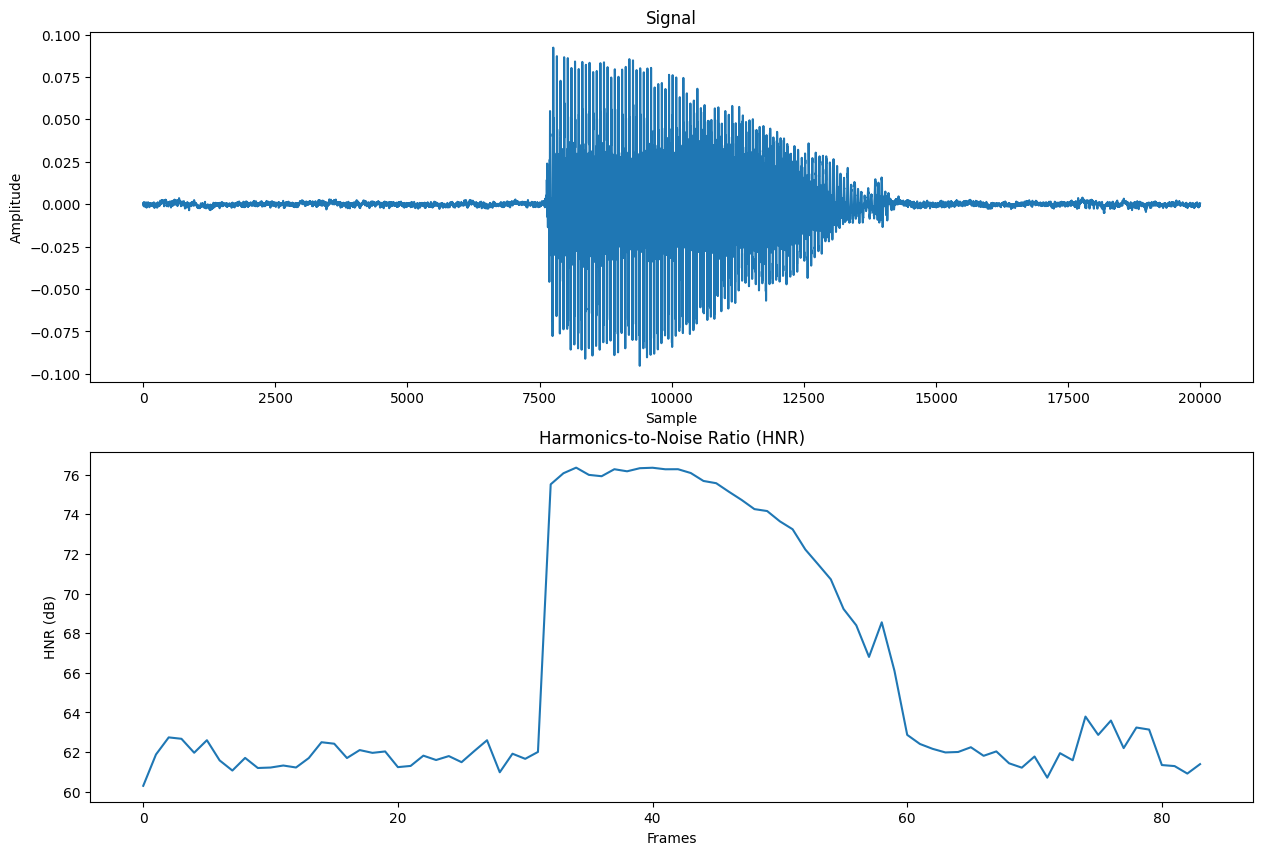

In [5]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 1, 1)
plt.plot(x)
plt.title('Signal')
plt.xlabel('Sample')
plt.ylabel('Amplitude')

plt.subplot(2, 1, 2)
plt.plot(HNR)
plt.xlabel('Frames')
plt.ylabel('HNR (dB)')
plt.title('Harmonics-to-Noise Ratio (HNR)')

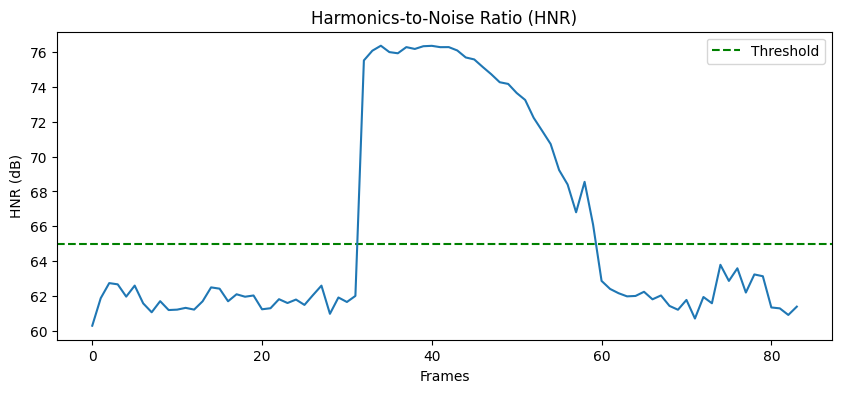

In [6]:
threshold = 65  # Ngưỡng HNR

# Vẽ biểu đồ HNR
frames = np.arange(len(HNR))  # Mảng các frame

valid_frames = np.where(HNR >= threshold)[0]

plt.figure(figsize=(10, 4))

plt.axhline(y=threshold, color='green', linestyle='--', label='Threshold')  # Vẽ đường ngưỡng HNR
plt.plot(HNR)
plt.xlabel('Frames')
plt.ylabel('HNR (dB)')
plt.title('Harmonics-to-Noise Ratio (HNR)')
plt.legend()
plt.show()

In [7]:
def remove_slient_frames_using_hnr(x, frame_length, hop_length):
    threshold = 65  # Ngưỡng HNR
    
    frames = np.arange(len(HNR))  # Mảng các frame
    
    # Tạo danh sách các frame mà HNR >= ngưỡng
    valid_frames = np.where(HNR >= threshold)[0]
    
    # Nếu không có frame nào thỏa mãn, trả về mảng trống
    if len(valid_frames) == 0:
        return []
    
    # Tính các chỉ số sample tương ứng với các frame đầu và cuối hợp lệ
    start_sample_index = librosa.frames_to_samples(valid_frames[0], hop_length=hop_length)
    end_sample_index = librosa.frames_to_samples(valid_frames[-1] + 1, hop_length=hop_length)
    
     # Trả về đoạn âm thanh sau khi loại bỏ các frame không hợp lệ
    return x[start_sample_index:end_sample_index]

In [8]:
y = remove_slient_frames_using_hnr(x, frame_length, hop_length)

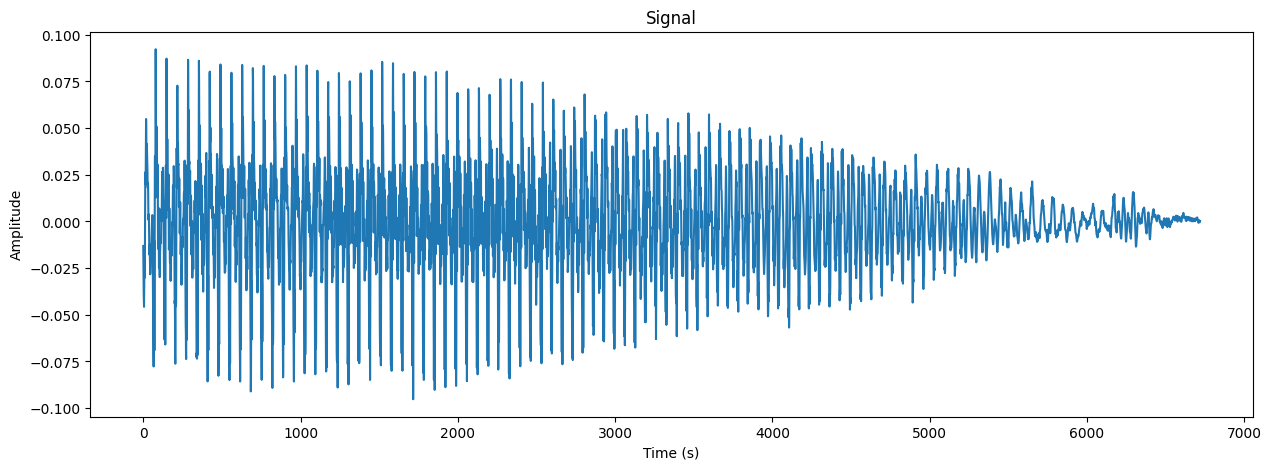

In [9]:
# plot the trimmed signal
plt.figure(figsize=(15, 5))
plt.plot(y)
plt.title('Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

In [10]:
def split_segments(index_voices: list) -> list:
    start = index_voices[0]
    segments = []
    for i in range(1, len(index_voices)):
        if index_voices[i] - index_voices[i-1] > 1:
            segments.append((start, index_voices[i-1]))
            start = index_voices[i]
    segments.append((start, index_voices[-1]))
    return segments

In [11]:
segments = split_segments(valid_frames)
segments

[(32, 59)]

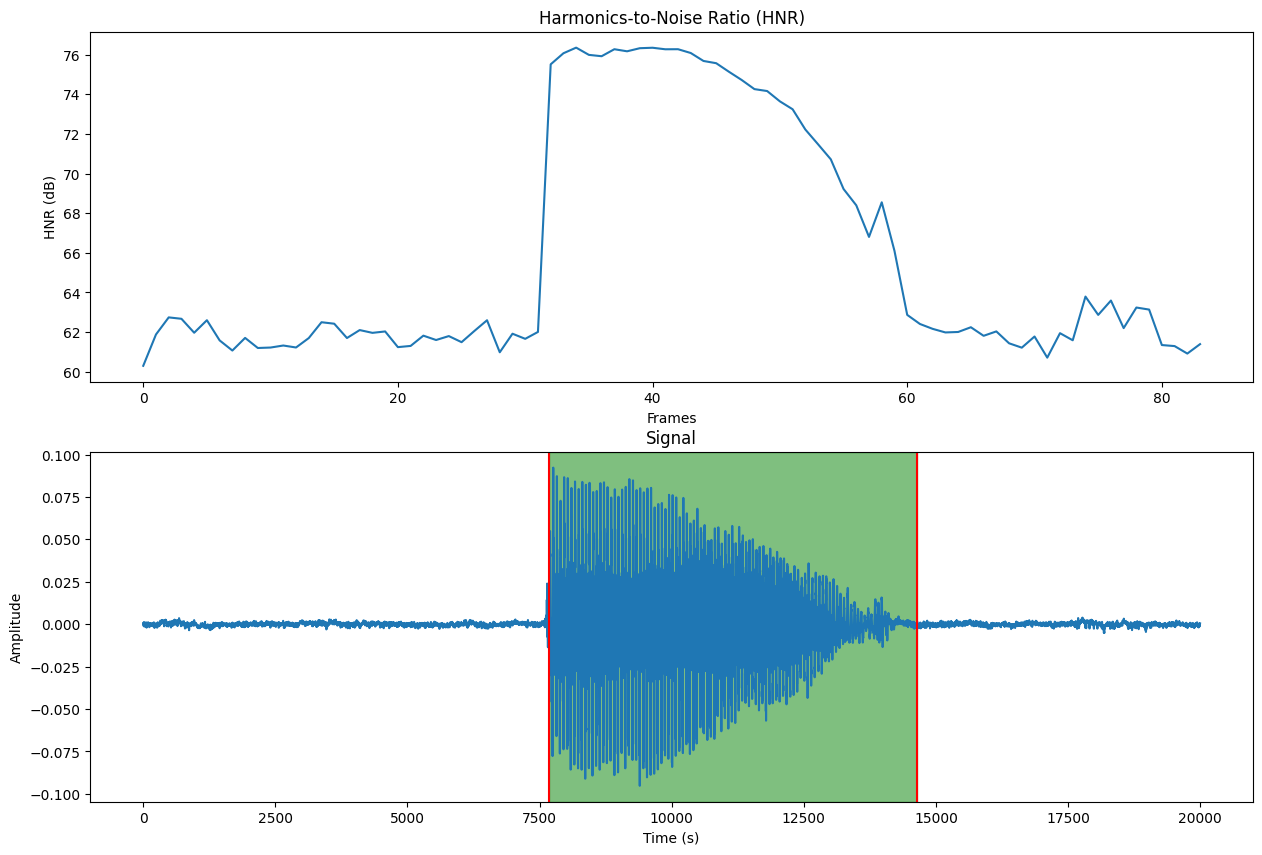

In [12]:
# plot the trimmed signal
plt.figure(figsize=(15, 10))

plt.subplot(2, 1, 1)
plt.plot(HNR)
plt.xlabel('Frames')
plt.ylabel('HNR (dB)')
plt.title('Harmonics-to-Noise Ratio (HNR)')

plt.subplot(2, 1, 2)
plt.plot(x)
# Đánh dấu tần số cơ bản (F0) trên đồ thị phổ tần số
for i in segments:
    # define start and end of the segment
    start_sample_index = librosa.frames_to_samples(i[0], hop_length=hop_length)
    end_sample_index = librosa.frames_to_samples(i[1], hop_length=hop_length) + frame_length

    plt.axvline(start_sample_index, color='r')
    # fill the segment with green color
    plt.axvspan(start_sample_index, end_sample_index, color='g', alpha=0.5)
    plt.axvline(end_sample_index, color='r')
    
plt.title('Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

# 3. Tìm F0 sử dụng FFT

In [32]:
from scipy.signal import find_peaks
# Lấy đoạn tín hiệu từ start_sample đến end_sample
N = len(y)
T = 1.0 / sr
t = np.linspace(0.0, N*T, N, endpoint=False)

In [33]:
# Áp dụng biến đổi Fourier nhanh (FFT) cho đoạn đã chọn
window = np.hanning(len(y))
yf = fft(y * window)
xf = fftfreq(N, T)[:N//2]

# Lấy giá trị phổ biên độ của FFT (giá trị thực)
amplitude_spectrum = 2.0/N * np.abs(yf[0:N//2])

In [43]:
# Lọc các tần số dưới 1 kHz
mask = xf < 1000

# Lấy giá trị phổ biên độ và tần số cho các giá trị dưới 1 kHz
xf_filtered = xf[mask]
amplitude_spectrum_filtered = amplitude_spectrum[mask]

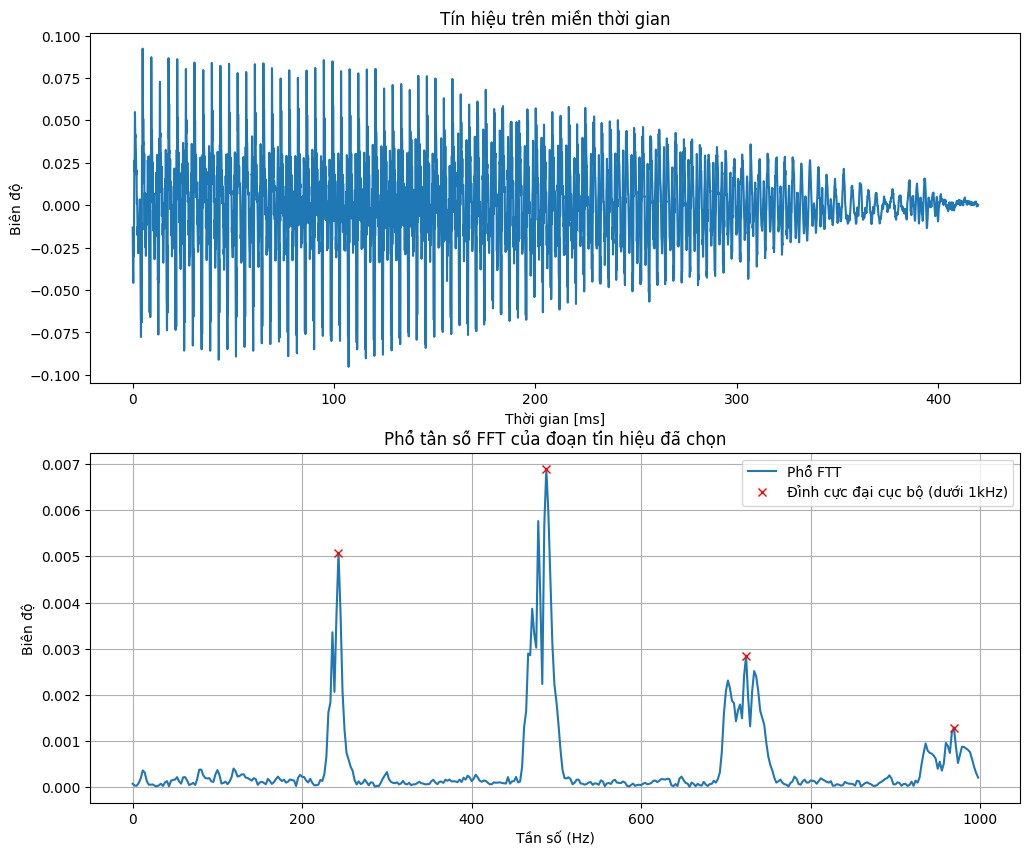

Tần số: 242.86 Hz, Biên độ: 0.0051
Tần số: 488.10 Hz, Biên độ: 0.0069
Tần số: 723.81 Hz, Biên độ: 0.0028
Tần số: 969.05 Hz, Biên độ: 0.0013


In [65]:
peaks, properties = find_peaks(amplitude_spectrum_filtered, height=0.0005, distance=20)

# Vẽ tín hiệu và phổ tần số cho đoạn đã chọn
plt.figure(figsize=(12, 10))

# Vẽ tín hiệu trên miền thời gian (chuyển từ giây sang mili giây)
plt.subplot(2, 1, 1)
plt.plot(t * 1000, y)  # Chuyển đổi thời gian sang ms
plt.title('Tín hiệu trên miền thời gian')
plt.xlabel('Thời gian [ms]')
plt.ylabel('Biên độ')

plt.subplot(2, 1, 2)
plt.plot(xf_filtered, amplitude_spectrum_filtered, label="Phổ FTT")
plt.plot(xf_filtered[peaks], amplitude_spectrum_filtered[peaks], "rx", label="Đỉnh cực đại cục bộ (dưới 1kHz)")
plt.xlabel("Tần số (Hz)")
plt.ylabel("Biên độ")
plt.title("Phổ tần số FFT của đoạn tín hiệu đã chọn")
plt.legend()
plt.grid()
plt.show()

# In ra các đỉnh tần số 
for i in sorted_top_5_peaks:
    print(f"Tần số: {xf_filtered[i]:.2f} Hz, Biên độ: {amplitude_spectrum_filtered[i]:.4f}")